# Price Data Exploration

This notebook is an exploration of price/billing data at Komodo. The effort aims at gathering enough insight to produce a model for prices across the encounters map in the hopes of imputing estimates for missing/corrupt data. 

## Notebook Setup and Local Functions

### Install packages

In [2]:
#install h20 for modeling exploration, need to set this up on hub
!pip install h2o

### Import libraries

In [3]:
#basic math/stats/graphs libraries
import h2o
import numpy as np
from numpy import sqrt, exp, log
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from math import ceil, floor
from ipywidgets import Layout, Button, Box, FloatText, Textarea,Dropdown, Label, IntSlider, Checkbox, interact, interactive
sns.set_style("whitegrid")

In [4]:
#basic model/pandas libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from datetime import datetime

In [5]:
#install snowflake connector
import sys 
#pull in snowflake login snippets
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


### Define functions

In [6]:
#generic function to pull in table from snowflake

def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"',
               select_statement=None, limit=None, where=None, 
               diag=False, sample_n=None):
    
    if select_statement is not None:
        sql=select_statement 
    
    else:
        sql = f"""select * 
         from {db}
        """ 
    if sample_n is not None:
        sql+=f""" sample row ({sample_n} rows) 
        """ 
    if where is not None:
        sql+=f""" where {where} 
        """
    if limit is not None:
        sql+=f""" limit {limit}
        """
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        print(sql)
        return sql

#function for summarizing data within snowflake
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['count','stddev','min', '1percentile', '5percentile',
                                      '10percentile','25percentile',
                                     'average','median','75percentile','90percentile',
                                      '95percentile','99percentile','max']):
    sql = f"""select 
        count(*) as count
        ,stddev({x}) as stddev
        ,min({x}::float) as min
        ,approx_percentile({x}::float,.01) as percentile_1
        ,approx_percentile({x}::float,.05) as percentile_5
        ,approx_percentile({x}::float,.1) as percentile_10
        ,approx_percentile({x}::float,.25) as percentile_25
        ,avg({x}::float) as average
        ,median({x}::float) as median
        ,approx_percentile({x}::float,.75) as percentile_75
        ,approx_percentile({x}::float,.9) as percentile_90
        ,approx_percentile({x}::float,.95) as percentile_95
        ,approx_percentile({x}::float,.99) as percentile_99
         ,max({x}::float) as max
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

### Define Databases

In [7]:
#encounters database
enc_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ENCOUNTERSMX_LS_GA"'

#allowed amounts database
aa_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ALLOWEDAMOUNTS_GA"'

#enhanced allowed amounts database (Jan, Feb 2020)
aa_enh_db='"SANDBOX_KRAO"."EDA"."ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.01% sample)
aa_enh_db_001pct='"SANDBOX_KRAO"."EDA"."RANDOM_001PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.1% sample)
aa_enh_db_01pct='"SANDBOX_KRAO"."EDA"."RANDOM_01PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#sum costs per patient and soc
aa_sum_cost_pp_soc='"SANDBOX_KRAO"."EDA"."SUM_COST_PER_PATIENT_SOC"'

#sum costs per patient and soc (1 M sample)
aa_sum_cost_pp_soc_1M='"SANDBOX_KRAO"."EDA"."SUM_COST_PER_PATIENT_SOC_1M_SAMPLE"'

In [8]:
#create pandas data frames for 1% samples
aa_enh_db_01pct_df=pull_snfdb(db=aa_enh_db_01pct)
aa_enh_db_01pct_df["LINE_CHARGE"]=aa_enh_db_01pct_df["LINE_CHARGE"].astype(float)

#create pandas data frames for .1% samples
aa_enh_db_001pct_df=pull_snfdb(db=aa_enh_db_001pct)
aa_enh_db_001pct_df["LINE_CHARGE"]=aa_enh_db_001pct_df["LINE_CHARGE"].astype(float)

## Inspect Data

In [10]:
aa_enh_db_01pct_df.head(5).T

,0,1,2,3,4
CLAIM_DATE,2020-02-06,2020-01-29,2020-01-23,2020-02-24,2020-02-12
ENCOUNTER_KEY,fc1dbfaf4cdbf888ee7f10431040c8d893107a0d,db0ffdcd057c8b15a0852806a41e56e43e361cb2,44503be8d23eb4ccd22e30a8bd5a092ca4c769fd,978eda1b13e804008020ea02d263ed2fa3b2119a,a4fabc30fb37246908f0f2cb8e9f43d919d9c7b4
VISIT_ID,8bd28fe420089f586899220679f438d0c22c7208,0801315f136bd16be4a43a42ed20da9f59f8dc41,e2b3c3944e333208102800e096badefadc3ca743,67276e5fae4d9e0fc8a16e29904c5d23fc94de87,3af070e51212eaa4076e093eb8455d642b333340
SOURCES_ARRAY,"[\n ""rowley""\n]","[\n ""fleming-peso""\n]","[\n ""fleming-peso""\n]","[\n ""pikato"",\n ""rowley""\n]","[\n ""fleming-peso""\n]"
PATIENT_STATE,IL,NY,FL,AL,PA
HCP_1_NPI,None,1649316894,None,1073092151,1659368736
HCO_1_NPI,1376521575,1447527320,1942630306,1447221056,1952398125
TOTAL_CLAIM_CHARGE_AMOUNT,NaN,546.7,650,NaN,1545
PAYER_KH_ID,17,195,221,343,186
PAYER_KH_ID_IMPUTE_FLAG,False,False,False,False,False


### Check to see if enhanced allowed amounts and allowed amounts distribution similarly

In [10]:
#basic stats for enhanced_allowed_amount
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=aa_enh_db)

,ALLOWED_AMOUNT_count,ALLOWED_AMOUNT_stddev,ALLOWED_AMOUNT_min,ALLOWED_AMOUNT_1percentile,ALLOWED_AMOUNT_5percentile,ALLOWED_AMOUNT_10percentile,ALLOWED_AMOUNT_25percentile,ALLOWED_AMOUNT_median,ALLOWED_AMOUNT_average,ALLOWED_AMOUNT_75percentile,ALLOWED_AMOUNT_90percentile,ALLOWED_AMOUNT_95percentile,ALLOWED_AMOUNT_99percentile,ALLOWED_AMOUNT_max
0,1322700508,6206.801074,0.01,1.189872,3.851389,6.985319,17.355797,167.128207,55.56,114.173997,223.457204,401.168767,1829.68082,99000000.0


In [11]:
#basic stats for allowed_amount
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=aa_db)

,ALLOWED_AMOUNT_count,ALLOWED_AMOUNT_stddev,ALLOWED_AMOUNT_min,ALLOWED_AMOUNT_1percentile,ALLOWED_AMOUNT_5percentile,ALLOWED_AMOUNT_10percentile,ALLOWED_AMOUNT_25percentile,ALLOWED_AMOUNT_median,ALLOWED_AMOUNT_average,ALLOWED_AMOUNT_75percentile,ALLOWED_AMOUNT_90percentile,ALLOWED_AMOUNT_95percentile,ALLOWED_AMOUNT_99percentile,ALLOWED_AMOUNT_max
0,9152760510,1.854537e+06,0.01,1.11295,3.495587,6.416157,16.88965,284.935148,54.34,113.047384,227.473583,437.756452,2560.829998,1.740174e+11


#### Note:  
Distributions similar, but all aa database has higher median, 95th, max values. 

### Inspect Distribution Plots of Amount Fields

In [9]:
#create interactive plot to graph distributions
#To do: Maybe add range slider


dist_max=max([aa_enh_db_01pct_df["ALLOWED_AMOUNT"].max(),aa_enh_db_01pct_df["TOTAL_CLAIM_CHARGE_AMOUNT"].max(),
             aa_enh_db_01pct_df["LINE_CHARGE"].max()])


def create_dist_range_slider (min_amt=0,max_amt=1,step=10):
    return widgets.IntRangeSlider(
        value=[min_amt,max_amt],
        min=min_amt,
        max=max_amt,
        description='DISTRIBUTION RANGE')

@widgets.interact_manual(
    amount_field=["ALLOWED_AMOUNT", "TOTAL_CLAIM_CHARGE_AMOUNT","LINE_CHARGE"])
def plot(amount_field="ALLOWED_AMOUNT", log_transform=False):
    data=aa_enh_db_01pct_df[[amount_field]]
    if log_transform:
        non_pos_count=len(data[data[amount_field]<=0])
        if non_pos_count>0:
            print("WARNING: NON-POSITIVE VALUES! DROPPING " + str(non_pos_count/len(data)) + " PERCENT OF OBSERVATIONS")
            data=data[data[amount_field]>0]
        data=log(data[[amount_field]]) 
    min_amt=int(floor(data.min()))
    max_amt=int(ceil(data.max()))
    #new_max=max_amt
    sns.distplot(data,
        label="1pct_sample", kde_kws={"shade": True},hist=False).set_title("Distribution:"+amount_field)

interactive(children=(Dropdown(description='amount_field', options=('ALLOWED_AMOUNT', 'TOTAL_CLAIM_CHARGE_AMOU…

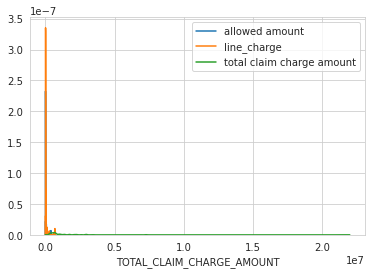

In [16]:
#overlay distribution of amount fields

sns.distplot(aa_enh_db_01pct_df["ALLOWED_AMOUNT"],
         kde_kws={"shade": True},label="allowed amount", hist=False)
sns.distplot(aa_enh_db_01pct_df["LINE_CHARGE"],
        label="line_charge", hist=False)
sns.distplot(aa_enh_db_01pct_df["TOTAL_CLAIM_CHARGE_AMOUNT"],label="total claim charge amount", hist=False)

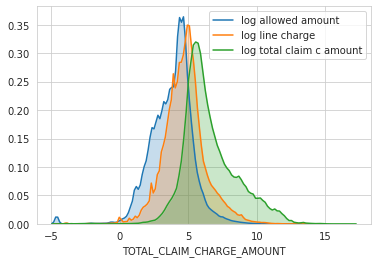

In [17]:
#overlay distributions of log amounts

log_aa_data=log(aa_enh_db_01pct_df["ALLOWED_AMOUNT"])
log_lc_data=log(aa_enh_db_01pct_df.loc[aa_enh_db_01pct_df["LINE_CHARGE"]>0,"LINE_CHARGE"])
log_tcca_data=log(aa_enh_db_01pct_df.loc[aa_enh_db_01pct_df["TOTAL_CLAIM_CHARGE_AMOUNT"]>0,
                                         "TOTAL_CLAIM_CHARGE_AMOUNT"])

sns.distplot(log_aa_data,
         kde_kws={"shade": True},label="log allowed amount", hist=False)
sns.distplot(log_lc_data,
        kde_kws={"shade": True},label="log line charge", hist=False)
sns.distplot(log_tcca_data,label="log total claim c amount",kde_kws={"shade": True}, hist=False)


In [38]:
#basic stats for cost per patient

#basic stats for enhanced_allowed_amount
pull_snfdb_dist_summ(x='AA_TOTAL', db=aa_sum_cost_pp_soc)

,AA_TOTAL_count,AA_TOTAL_stddev,AA_TOTAL_min,AA_TOTAL_1percentile,AA_TOTAL_5percentile,AA_TOTAL_10percentile,AA_TOTAL_25percentile,AA_TOTAL_average,AA_TOTAL_median,AA_TOTAL_75percentile,AA_TOTAL_90percentile,AA_TOTAL_95percentile,AA_TOTAL_99percentile,AA_TOTAL_max
0,157080049,19810.982609,0.01,8.299075,29.371502,52.167175,102.874303,846.711731,198.28,470.124268,1225.953352,2364.991226,9299.652659,99018429.56


### Inspect Fill Rates Plots of Amount Fields

#### Fill rates for all analysis data

In [38]:
#basic stats for enhanced_allowed_amount
temp_select_statement=f"""select count(encounter_key) as e_key_count
  ,1-((select count(encounter_key) 
  from """ + aa_enh_db + f"""where allowed_amount is NULL)/e_key_count) as allowed_amount_fill_rate
  ,1-((select count(encounter_key) 
  from """ + aa_enh_db + f"""where line_charge is NULL)/e_key_count) as line_charge_fill_rate
  ,1-((select count(encounter_key) 
  from """ + aa_enh_db + f"""where total_claim_charge_amount is NULL)/e_key_count) as total_claim_amount_fill_rate
  from""" + aa_enh_db 

pull_snfdb(select_statement=temp_select_statement)
    

,E_KEY_COUNT,ALLOWED_AMOUNT_FILL_RATE,LINE_CHARGE_FILL_RATE,TOTAL_CLAIM_AMOUNT_FILL_RATE
0,1322700508,0.225462,0.71288,0.766781


#### Note:  
Low fill rate for allowed amounts, much higher for line_charge and total_claim_amount

### Compare Dist of Claims w/Amounts vs no Amounts

### Summarize allowed amounts by procedure

In [9]:
#basic stats for enhanced_allowed_amount

temp_select_statement=f""" select procedure
        , procedure_description
        ,count(distinct encounter_key) as count_ekey
        ,count(line_charge) as count_lc
        ,count(total_claim_charge_amount) as count_tcca
        ,count(ALLOWED_AMOUNT) as count_aa
        ,stddev(ALLOWED_AMOUNT) as stddev_aa
        ,min(ALLOWED_AMOUNT::float) as min_aa
        ,avg(ALLOWED_AMOUNT::float) as average_aa
        ,median(ALLOWED_AMOUNT::float) as median_aa
         ,max(ALLOWED_AMOUNT::float) as max_aa
      from """ + aa_enh_db
temp_select_statement+=f""" where procedure is not NULL"""
temp_select_statement+=f""" group by procedure, procedure_description"""
temp_select_statement+=f""" order by count_aa DESC"""

px_proc_summary=pull_snfdb(select_statement=temp_select_statement, diag=False)

In [11]:
px_proc_summary["AA_EKEY_PCT"]=px_proc_summary["COUNT_AA"]/px_proc_summary["COUNT_EKEY"]
#px_proc_summary["AA_LC"]=px_proc_summary["AVERAGE_AA"]/px_proc_summary["AVERAGE_LC"]
#px_proc_summary["AA_TCCA"]=px_proc_summary["AVERAGE_AA"]/px_proc_summary["AVERAGE_TCCA"]

In [12]:
px_proc_summary.head(100).T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
PROCEDURE,"""99213""","""99214""","""97110""","""97140""","""97530""","""36415""","""97112""","""87804""","""85025""","""T1019""",...,"""20610""","""83735""","""97161""","""99291""","""96127""","""82570""","""99211""","""98940""","""82607""","""99393"""
PROCEDURE_DESCRIPTION,Established patient office or other outpatient...,Established patient office or other outpatient...,"Therapeutic exercise to develop strength, endu...",Manual (physical) therapy techniques to 1 or m...,"Therapeutic activities to improve function, wi...",Insertion of needle into vein for collection o...,Therapeutic procedure to re-educate brain-to-n...,Detection test for influenza virus,"Complete blood cell count (red cells, white bl...","Personal care services, per 15 minutes, not fo...",...,Aspiration and/or injection of large joint or ...,Magnesium level,"Evaluation of physical therapy, typically 20 m...",Critical care delivery critically ill or injur...,Brief emotional or behavioral assessment,Creatinine level to test for kidney function o...,Established patient office or other outpatient...,"Chiropractic manipulative treatment, 1-2 spina...",Cyanocobalamin (vitamin B-12) level,Established patient periodic preventive medici...
COUNT_EKEY,52680661,43862912,20449621,13648699,9321462,25071544,8232135,6274038,19730317,5373515,...,1339722,3063422,1451308,1518071,1688142,2466696,2249226,2397263,2542964,1459194
COUNT_LC,38633224,32875149,22138417,13256869,10870573,19117863,8496616,7321066,15183258,6545774,...,1128290,2501348,1216288,1403905,1177823,1827904,1610699,2094603,1790299,1030655
COUNT_TCCA,40924456,34862861,24357122,14617977,11989994,19878768,9388270,8060663,15954686,6800261,...,1232178,2649272,1353915,1480664,1251266,1941849,1736522,2204553,1898249,1161465
COUNT_AA,17009459,15592123,10337502,5839774,5228959,4683305,4230752,4017989,3720501,3414900,...,548415,546337,531304,528774,501879,499299,498361,496734,485934,484813
STDDEV_AA,56.0328,66.9722,102.837,43.4738,100.71,487.186,87.3815,136.97,1099.21,124.165,...,199.494,1767.91,450.8,427.836,29.6585,1244.19,83.7301,141.111,1261.51,84.5818
MIN_AA,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
AVERAGE_AA,81.917,116.64,58.253,36.858,62.3919,17.9066,44.591,22.5934,55.8362,131.997,...,101.07,80.9498,96.8043,316.245,11.9106,26.644,36.6542,30.9031,42.247,115.915
MEDIAN_AA,74.84,107.91,47.1,24.42,46.45,3,33.73,16.44,7.77,102.56,...,69.21,6.7,82.82,227.12,6.95,5.18,22.61,27.47,14.99,103.47


In [14]:
#summarize proc-price level data

px_proc_summary[['AVERAGE_AA','MEDIAN_AA','STDDEV_AA']].describe()

,AVERAGE_AA,MEDIAN_AA,STDDEV_AA
count,2.920100e+04,2.920100e+04,2.333300e+04
mean,1.109295e+04,9.140766e+03,9.298833e+03
std,3.592900e+04,3.380425e+04,3.209863e+04
min,1.000000e-02,1.000000e-02,0.000000e+00
25%,3.140841e+02,1.879700e+02,2.118663e+02
50%,2.052344e+03,1.598060e+03,1.198261e+03
75%,1.068250e+04,8.756470e+03,5.124999e+03
max,1.412862e+06,1.412862e+06,1.171933e+06


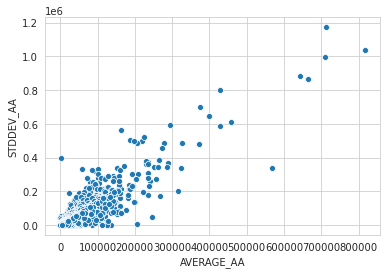

In [15]:
#plot stddev vs mean
ax = sns.scatterplot(y='STDDEV_AA', x='AVERAGE_AA', data=px_proc_summary)


#### Note:  
Std dev roughly proportional to mean

### Inspect/Model Data for Single Proc

In [9]:
temp_select_statement=f""" select * from """ + aa_enh_db 
temp_select_statement+=f""" where procedure='99213' and allowed_amount is not null"""
temp_select_statement+=f""" limit 100000 """

price_proc_sample=pull_snfdb(select_statement=temp_select_statement, diag=False)

In [10]:
price_proc_sample.columns

Index(['CLAIM_DATE', 'UPK_KEY2', 'ENCOUNTER_KEY', 'VISIT_ID', 'SOURCES_ARRAY',
       'PATIENT_STATE', 'HCP_1_NPI', 'HCO_1_NPI', 'TOTAL_CLAIM_CHARGE_AMOUNT',
       'PAYER_KH_ID', 'PAYER_KH_ID_IMPUTE_FLAG', 'BILL_TYPE_CODE',
       'PAYER_CHANNEL', 'STATEMENT_FROM', 'STATEMENT_TO',
       'DISCHARGE_STATUS_CODE', 'CLAIM_TYPE_CODE', 'ADMIT_TYPE_CODE',
       'LINE_CHARGE', 'NDC', 'DATE_OF_SERVICE', 'SL_SERVICE_FROM',
       'SL_SERVICE_TO', 'PROCEDURE', 'MODIFIER_1', 'MODIFIER_2', 'MODIFIER_3',
       'MODIFIER_4', 'UNITS', 'PLACE_OF_SERVICE', 'DIAGNOSIS_CODE_1',
       'DIAGNOSIS_CODE_2', 'DIAGNOSIS_CODE_3', 'DIAGNOSIS_CODE_4',
       'REVENUE_CODE', 'EMERGENCY_INDICATOR', 'HCO_S_1_NPI', 'HCP_S_1_NPI',
       'HCP_S_2_NPI', 'SERVICE_LINE_NUMBER', 'SOURCE_ROWLEY', 'SOURCE_FSALK',
       'SOURCE_FPESO', 'SOURCE_FNIGHT', 'PROCEDURE_DESCRIPTION',
       'VISIT_SETTING_OF_CARE', 'ALLOWED_AMOUNT'],
      dtype='object')

#### Inspect Fill Rate

In [11]:
1-price_proc_sample.isnull().sum()/len(price_proc_sample)

CLAIM_DATE                   1.00000
UPK_KEY2                     1.00000
ENCOUNTER_KEY                1.00000
VISIT_ID                     1.00000
SOURCES_ARRAY                1.00000
PATIENT_STATE                0.98623
HCP_1_NPI                    0.95280
HCO_1_NPI                    0.98462
TOTAL_CLAIM_CHARGE_AMOUNT    0.86119
PAYER_KH_ID                  0.99178
PAYER_KH_ID_IMPUTE_FLAG      1.00000
BILL_TYPE_CODE               0.02415
PAYER_CHANNEL                0.99737
STATEMENT_FROM               0.01474
STATEMENT_TO                 0.01468
DISCHARGE_STATUS_CODE        0.02106
CLAIM_TYPE_CODE              1.00000
ADMIT_TYPE_CODE              0.01470
LINE_CHARGE                  0.84225
NDC                          0.00000
DATE_OF_SERVICE              0.99971
SL_SERVICE_FROM              1.00000
SL_SERVICE_TO                1.00000
PROCEDURE                    1.00000
MODIFIER_1                   0.23354
MODIFIER_2                   0.00648
MODIFIER_3                   0.00016
M

#### Pull Certain Fields
Add Modifiers, dx codes?

In [51]:
temp_select_statement=f""" select ALLOWED_AMOUNT, PATIENT_STATE, PAYER_KH_ID, 
      PAYER_CHANNEL, CLAIM_TYPE_CODE, MODIFIER_1, MODIFIER_2, UNITS, PLACE_OF_SERVICE, VISIT_SETTING_OF_CARE as SOC
      from """ + aa_enh_db 
temp_select_statement+=f""" where procedure='99213' and allowed_amount is not null """


sample_proc_price_pull=pull_snfdb(select_statement=temp_select_statement, diag=False)
sample_proc_price_pull['LOG_ALLOWED_AMOUNT']=log(sample_proc_price_pull['ALLOWED_AMOUNT'])

In [13]:
sample_proc_price_pull.head().T

,0,1,2,3,4
ALLOWED_AMOUNT,111.09,77.27,84.85,138.41,71.34
PATIENT_STATE,IL,NC,NJ,MN,TX
PAYER_KH_ID,186,189,195,62,266
PAYER_CHANNEL,Commercial,Commercial,Medicare,Commercial,Commercial
CLAIM_TYPE_CODE,P,P,P,P,P
MODIFIER_1,"""25""",None,None,None,None
MODIFIER_2,None,None,None,None,None
UNITS,1,None,1,1,None
PLACE_OF_SERVICE,"""11""","""11""","""11""","""11""","""11"""
SOC,Outpatient Visit,Outpatient Visit,Outpatient Visit,Outpatient Visit,Outpatient Visit


#### Calc Unique Values for Fields

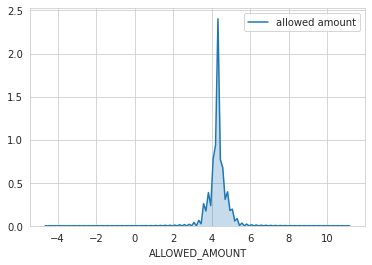

In [15]:
sns.distplot(log(sample_proc_price_pull["ALLOWED_AMOUNT"]),
         kde_kws={"shade": True},label="allowed amount", hist=False)

In [16]:
sample_proc_price_pull.apply(lambda x: len(x.unique()))

ALLOWED_AMOUNT      27436
PATIENT_STATE          53
PAYER_KH_ID           344
PAYER_CHANNEL           9
CLAIM_TYPE_CODE         2
MODIFIER_1            220
MODIFIER_2            153
UNITS                  29
PLACE_OF_SERVICE       38
SOC                     9
dtype: int64

#### Inspect Distribution of Price by Setting of Care

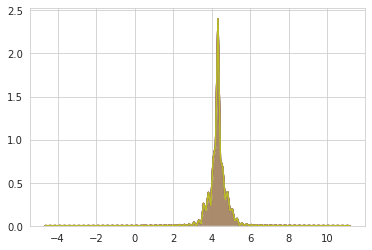

In [18]:
soc_list = sample_proc_price_pull['SOC'].unique()  
pd_list = [sample_proc_price_pull.loc[sample_proc_price_pull['SOC'] == soc] for soc in soc_list]

for pd_temp in pd_list:
    sns.distplot(log(sample_proc_price_pull[['ALLOWED_AMOUNT']]), kde_kws={"shade": True},hist=False)

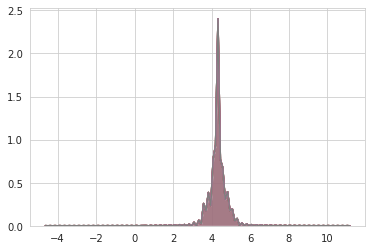

In [19]:
#exclude Outpatient for Visibility

pd_list_2 = [sample_proc_price_pull.loc[sample_proc_price_pull['SOC'] == soc] for soc in soc_list if soc!='Outpatient Visit']

for pd_temp in pd_list_2:
    sns.distplot(log(sample_proc_price_pull[['ALLOWED_AMOUNT']]), kde_kws={"shade": True},hist=False)

In [24]:
sample_proc_price_pull[sample_proc_price_pull.ALLOWED_AMOUNT.notnull()] \
.groupby("SOC") \
.agg({'ALLOWED_AMOUNT':['count','min', 'max','mean','median']}) \
.reset_index().droplevel(0, axis=1).sort_values('count', ascending=False)

,,count,min,max,mean,median
6,Outpatient Visit,16945766,0.01,69110.0,81.915608,74.840
4,Laboratory Visit,21835,5.00,2200.0,94.402332,77.770
2,Home Visit,4174,21.54,322.4,81.336900,59.845
5,Non-hospital institution Visit,3866,8.67,1083.0,126.068316,145.000
3,Inpatient Visit,3086,0.01,4395.0,78.624342,60.000
1,Emergency Room Visit,2182,0.01,2400.0,117.709060,80.550
7,Pharmacy Visit,98,23.50,250.0,60.831327,49.840
0,Ambulance Visit,52,37.00,1508.0,126.139615,76.265


#### Note:  
High 4th moment for all socs

#### Inspect Distribution of Price by Payer Channel

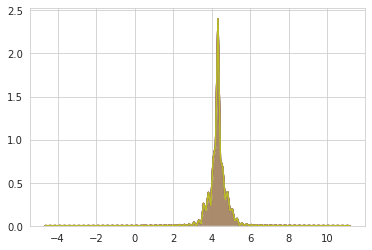

In [21]:
pc_list = sample_proc_price_pull['PAYER_CHANNEL'].unique()  
pd_list = [sample_proc_price_pull.loc[sample_proc_price_pull['PAYER_CHANNEL'] == pc] for pc in pc_list]

for pd_temp in pd_list:
    sns.distplot(log(sample_proc_price_pull[['ALLOWED_AMOUNT']]), kde_kws={"shade": True},hist=False)

In [23]:
sample_proc_price_pull[sample_proc_price_pull.ALLOWED_AMOUNT.notnull()] \
.groupby("PAYER_CHANNEL") \
.agg({'ALLOWED_AMOUNT':['count','min', 'max','mean','median']}) \
.reset_index().droplevel(0, axis=1).sort_values('count', ascending=False)

,,count,min,max,mean,median
0,Commercial,11324737,0.01,69110.0,86.794484,78.190
1,Managed Medicaid,2472318,0.01,35832.0,68.538045,55.460
3,Medicare,1650712,0.01,38901.0,75.940247,73.230
4,Medicare Advantage,1202125,0.01,25139.5,74.647812,72.770
2,Medicaid,182632,0.02,8503.2,64.677061,61.090
5,TRICARE,99144,0.01,446.0,67.992250,66.540
6,Veterans Affairs,30879,0.01,670.0,72.783150,71.890
7,Workers Comp,4818,2.40,383.0,102.630455,96.335


#### Note:  
No meaningful difference for payers?

#### Inspect Dist by Modifier

use box plots?

In [22]:
sample_proc_price_pull[sample_proc_price_pull.ALLOWED_AMOUNT.notnull()] \
.groupby("MODIFIER_1") \
.agg({'ALLOWED_AMOUNT':['count','min', 'max','mean','median']}) \
.reset_index().droplevel(0, axis=1).sort_values('count', ascending=False)

,,count,min,max,mean,median
15,"""25""",3418277,0.01,32400.00,80.748999,74.15
165,"""SA""",145434,0.01,518.56,75.253567,63.77
14,"""24""",56541,0.01,3460.00,81.368538,74.70
185,"""TH""",45979,0.01,673.50,50.783575,36.89
66,"""CG""",39567,0.01,38901.00,143.224066,123.00
...,...,...,...,...,...,...
178,"""T7""",1,69.50,69.50,69.500000,69.50
179,"""T8""",1,69.00,69.00,69.000000,69.00
68,"""CO""",1,76.52,76.52,76.520000,76.52
67,"""CH""",1,200.00,200.00,200.000000,200.00


#### Note:  
Hard to track down modifier meanings. Average allowed_amount can be sign?  higher for certain modifiers related to complications and multiple prodcerures

#### Model 

In [25]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_282"; OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08); OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplp7m40du
  JVM stdout: /tmp/tmplp7m40du/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmplp7m40du/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_jovyan_mafprj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10 Gb
H2O_cluster_total_cores:,7
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"accepting new members, healthy"


In [57]:
#set up regression data frames
xNames=['PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'SOC']
yName='LOG_ALLOWED_AMOUNT'

px_reg_df=sample_proc_price_pull[[yName]+xNames]

px_reg_df_sample=px_reg_df.sample(n=1000000, random_state=1)

In [60]:
#sample for init regression
X_train, X_test, y_train, y_test = train_test_split(px_reg_df_sample[xNames],
                                                px_reg_df_sample[yName],
                                                test_size=0.35, random_state=1)

In [62]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=300, seed=1)
trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train ], axis=1))
testH2o=h2o.H2OFrame(pd.concat([y_test,X_test], axis=1))
aml.train(x=xNames, y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
20:26:50.599: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [63]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20210405_202650,0.107505,0.327879,0.107505,0.187783,nan
StackedEnsemble_AllModels_AutoML_20210405_202650,0.107505,0.327879,0.107505,0.187783,nan
XGBoost_grid__1_AutoML_20210405_202650_model_1,0.108668,0.329649,0.108668,0.190347,nan
DRF_1_AutoML_20210405_202650,0.108968,0.330103,0.108968,0.18768,nan
GBM_grid__1_AutoML_20210405_202650_model_1,0.128995,0.359159,0.128995,0.211133,nan
GBM_4_AutoML_20210405_202650,0.132706,0.364289,0.132706,0.220211,nan
GBM_3_AutoML_20210405_202650,0.135299,0.367829,0.135299,0.2224,nan
GBM_2_AutoML_20210405_202650,0.135469,0.368062,0.135469,0.221388,nan
XRT_1_AutoML_20210405_202650,0.13711,0.370284,0.13711,0.224004,nan
DeepLearning_grid__1_AutoML_20210405_202650_model_1,0.137752,0.371149,0.137752,0.219168,nan


In [72]:
np.std(y_test)

0.43136369792337304

In [73]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20210405_202650

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.10446880715555884
RMSE: 0.3232163472901067
MAE: 0.18951796556605557
RMSLE: NaN
R^2: 0.4576164352163782
Mean Residual Deviance: 0.10446880715555884
Null degrees of freedom: 9924
Residual degrees of freedom: 9921
Null deviance: 1911.6637302703512
Residual deviance: 1036.8529110189215
AIC: 5756.677407680297

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.1075046661530959
RMSE: 0.32787904195464507
MAE: 0.1877830980686228
RMSLE: NaN
R^2: 0.42224976985371476
Mean Residual Deviance: 0.1075046661530959
Null degrees of freedom: 349999
Residual degrees of freedom: 349996
Null deviance: 65126.6842377732
Residual deviance: 37626.63315358356
AIC: 212689.61404487703

ModelMetricsRegressionGLM: stackedensemble
** Reported on 

In [ ]:
@widgets.interact_manual(
    amount_field=["ALLOWED_AMOUNT", "TOTAL_CLAIM_CHARGE_AMOUNT","LINE_CHARGE"])
def plot(amount_field="ALLOWED_AMOUNT", log_transform=False):
    data=aa_enh_db_01pct_df[[amount_field]]
    if log_transform:
        non_pos_count=len(data[data[amount_field]<=0])
        if non_pos_count>0:
            print("WARNING: NON-POSITIVE VALUES! DROPPING " + str(non_pos_count/len(data)) + " PERCENT OF OBSERVATIONS")
            data=data[data[amount_field]>0]
        data=log(data[[amount_field]]) 
    min_amt=int(floor(data.min()))
    max_amt=int(ceil(data.max()))
    #new_max=max_amt
    sns.distplot(data,
        label="1pct_sample", kde_kws={"shade": True},hist=False).set_title("Distribution:"+amount_field)

### Inspect Conditional Distributions of Amount Fields

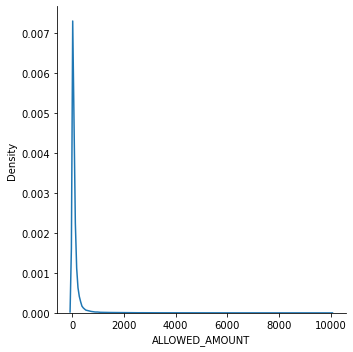

In [21]:
sns.displot(data=aa_enh_db_01pct_df[aa_enh_db_01pct_df.ALLOWED_AMOUNT<10000].ALLOWED_AMOUNT, kind="kde",label="allowed_amount")    
#dist_vals=sns.distplot(trunc_df.dropna().LINE_CHARGE, hist_kws={'weights':trunc_df.dropna().PATIENT_COUNT},
#                hist=False, label="line_charge").get_lines()[0].get_data()

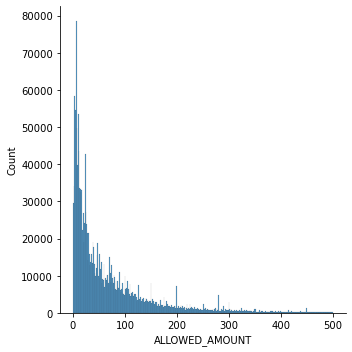

In [25]:
sns.displot(data=aa_enh_db_01pct_df[aa_enh_db_01pct_df.ALLOWED_AMOUNT<500].ALLOWED_AMOUNT, label="allowed_amount")    
#dist_vals=sns.distplot(trunc_df.dropna().LINE_CHARGE, hist_kws={'weights':trunc_df.dropna().PATIENT_COUNT},
#                hist=False, label="line_charge").get_lines()[0].get_data()

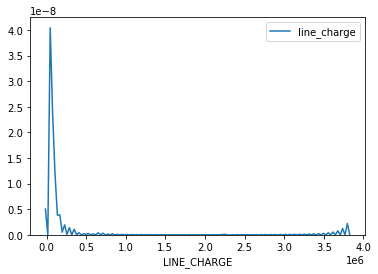

In [12]:
temp_df=aa_enh_db_01pct_df["LINE_CHARGE"].dropna()

sns.distplot(temp_df,
                hist=False,label="line_charge")
    
#dist_vals=sns.distplot(trunc_df.dropna().LINE_CHARGE, hist_kws={'weights':trunc_df.dropna().PATIENT_COUNT},
#                hist=False, label="line_charge").get_lines()[0].get_data()

#### Note:  
High fill rate for allowed_amount, much lower for line_charge, total_claim_amount

### Check on percentage of encounters with various amount fields, grouped by various fields 

In [ ]:
bill_type_code
* * setting of care
* * state
* * provider/payer

In [ ]:
dropdown_field = widgets.Dropdown(options = top_proc_list)

output_proc = widgets.Output()

In [40]:
#basic stats for enhanced_allowed_amount
temp_select_statement=f"""select count(distinct encounter_key) as e_key_count
  ,(select count(distinct encounter_key) 
  from """ + aa_enh_db + f"""where allowed_amount is NULL)/e_key_count as allowed_amount_fill_rate
  ,(select count(distinct encounter_key) 
  from """ + aa_enh_db + f"""where line_charge is NULL)/e_key_count as line_charge_fill_rate
  ,(select count(distinct encounter_key) 
  from """ + aa_enh_db + f"""where total_claim_charge_amount is NULL)/e_key_count as total_claim_amount_fill_rate
  from""" + aa_enh_db 

pull_snfdb(select_statement=temp_select_statement)
    

Output()

#### Note:  
High fill rate for allowed_amount, much lower for line_charge, total_claim_amount

In [ ]:
### Basic dr

* Average AA vs STDDEV AA-roughly proportional
* Average AA vs AVG LC-not proportional
* Average AA vs AVG TCCA-def not proportional

* fewer ekeys than amounts?
* difference between LC and AA
* AA as pct of TCCA

In [67]:
px_proc_summary[["PROCEDURE", "PROCEDURE_DESCRIPTION", "AA_EKEY_PCT", "AA_LC", "AA_TCCA"]].describe()

Output()

### Notes

#### ToDo:
##### High-Level Price Stats
* Rerun sampling schema
* Fill rate for line charge and claim_bill etc
* Fill rate by groups
* * bill_type_code
* * setting of care
* * state
* * provider/payer
##### Stats per Procedure
* Interactive chart
* * setting of care, payer/provider
##### Investigate difference between amount categories
* Amounts where allowed_amount is available but not others
##### Tooling
* disable autovizwidget/transpose

## OLD CODE (DEPRECATED)

### Interactive Distribution

In [52]:
@widgets.interact_manual(
    amount_field=["ALLOWED_AMOUNT", "TOTAL_CLAIM_CHARGE_AMOUNT","LINE_CHARGE"])
def plot(amount_field="ALLOWED_AMOUNT", log_transform=False):
    data=aa_enh_db_01pct_df[[amount_field]]
    if log_transform:
        non_pos_count=len(data[data[amount_field]<=0])
        if non_pos_count>0:
            print("WARNING: NON-POSITIVE VALUES! DROPPING " + str(non_pos_count/len(data)) + " PERCENT OF OBSERVATIONS")
            data=data[data[amount_field]>0]
        data=log(data[[amount_field]])
    min_amt=int(floor(data.min()))
    max_amt=int(ceil(data.max()))
    dist_range_slider=create_dist_range_slider(min_amt, max_amt)
    display(dist_range_slider)
    dist_range=dist_range_slider.value
    #new_max=max_amt
    print(dist_range)
    sns.distplot(data[(data>=min_amt) & (data<=max_amt)],
        label="1pct_sample", hist=False).set_title("Distribution:"+amount_field)

interactive(children=(Dropdown(description='amount_field', options=('ALLOWED_AMOUNT', 'TOTAL_CLAIM_CHARGE_AMOU…

In [13]:
dist_max=max([aa_enh_db_01pct_df["ALLOWED_AMOUNT"].max(),aa_enh_db_01pct_df["TOTAL_CLAIM_CHARGE_AMOUNT"].max(),
             aa_enh_db_01pct_df["LINE_CHARGE"].max()])


def create_dist_range_slider (min_amt=0,max_amt=1,step=10):
    return widgets.IntRangeSlider(
        value=[min_amt,max_amt],
        min=min_amt,
        max=max_amt,
        description='DISTRIBUTION RANGE')

@widgets.interact_manual(
    amount_field=["ALLOWED_AMOUNT", "TOTAL_CLAIM_CHARGE_AMOUNT","LINE_CHARGE"])
def plot(amount_field="ALLOWED_AMOUNT", log_transform=False,new_max=dist_max):
    data=aa_enh_db_01pct_df[[amount_field]]
    if log_transform:
        non_pos_count=len(data[data[amount_field]<=0])
        if non_pos_count>0:
            print("WARNING: NON-POSITIVE VALUES! DROPPING " + str(non_pos_count/len(data)) + " PERCENT OF OBSERVATIONS")
            data=data[data[amount_field]>0]
        data=log(data[[amount_field]]) 
    print(data.min())
    min_amt=int(floor(data.min()))
    max_amt=int(ceil(data.max()))
    #new_max=max_amt
    sns.distplot(data[data<=new_max],
        label="1pct_sample", hist=False).set_title("Distribution:"+amount_field)

interactive(children=(Dropdown(description='amount_field', options=('ALLOWED_AMOUNT', 'TOTAL_CLAIM_CHARGE_AMOU…

In [13]:
dist_max=max([aa_enh_db_01pct_df["ALLOWED_AMOUNT"].max(),aa_enh_db_01pct_df["TOTAL_CLAIM_CHARGE_AMOUNT"].max(),
             aa_enh_db_01pct_df["LINE_CHARGE"].max()])


def create_dist_range_slider (min_amt=0,max_amt=1,step=10):
    return widgets.IntRangeSlider(
        value=[min_amt,max_amt],
        min=min_amt,
        max=max_amt,
        description='DISTRIBUTION RANGE')

@widgets.interact_manual(
    amount_field=["ALLOWED_AMOUNT", "TOTAL_CLAIM_CHARGE_AMOUNT","LINE_CHARGE"])
def plot(amount_field="ALLOWED_AMOUNT", log_transform=False,new_max=dist_max):
    data=aa_enh_db_01pct_df[[amount_field]]
    if log_transform:
        non_pos_count=len(data[data[amount_field]<=0])
        if non_pos_count>0:
            print("WARNING: NON-POSITIVE VALUES! DROPPING " + str(non_pos_count/len(data)) + " PERCENT OF OBSERVATIONS")
            data=data[data[amount_field]>0]
        data=log(data[[amount_field]]) 
    print(data.min())
    min_amt=int(floor(data.min()))
    max_amt=int(ceil(data.max()))
    #new_max=max_amt
    sns.distplot(data[data<=new_max],
        label="1pct_sample", hist=False).set_title("Distribution:"+amount_field)

interactive(children=(Dropdown(description='amount_field', options=('ALLOWED_AMOUNT', 'TOTAL_CLAIM_CHARGE_AMOU…

### Install packages

In [2]:
!pip install h2o

Processing ./.cache/pip/wheels/0d/7b/36/4a326271b8c29b364de3641c44a651148578d34d9e11f71f6b/h2o-3.30.1.2-py2.py3-none-any.whl
Processing ./.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0/future-0.18.2-py3-none-any.whl
  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
  Using cached idna-2.8-py2.py3-none-any.whl (58 kB)
ERROR: snowflake-connector-python 2.2.0 has requirement botocore<1.15,>=1.5.0, but you'll have botocore 1.17.36 which is incompatible.
  Attempting uninstall: idna
    Found existing installation: idna 2.9
    Uninstalling idna-2.9:
      Successfully uninstalled idna-2.9


### Import libraries

In [3]:
import h2o
import numpy as np
from numpy import sqrt, exp
import seaborn as sns

In [5]:
import sys 
#pull in snowflake login snippets
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from datetime import datetime

### Define functions

In [7]:
#generic function to pull in table from snowflake

def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"', limit=None, where=None, diag=False, sample_n=None):
    sql = f"""select * 
         from {db}
        """ 
    if sample_n is not None:
        sql+=f""" sample row ({sample_n} rows) 
        """ 
    if where is not None:
        sql+=f""" where {where} 
        """
    if limit is not None:
        sql+=f""" limit {limit}
        """
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        print(sql)
        return sql

#function for summarizing data within snowflake
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['count','stddev','min', '1percentile', '5percentile',
                                      '10percentile','25percentile',
                                     'median','average','75percentile','90percentile',
                                      '95percentile','99percentile','max']):
    sql = f"""select 
        count(*) as count
        ,stddev({x}) as stddev
        ,min({x}::float) as min
        ,approx_percentile({x}::float,.01) as percentile_1
        ,approx_percentile({x}::float,.05) as percentile_5
        ,approx_percentile({x}::float,.1) as percentile_10
        ,approx_percentile({x}::float,.25) as percentile_25
        ,avg({x}::float) as average
        ,median({x}::float) as median
        ,approx_percentile({x}::float,.75) as percentile_75
        ,approx_percentile({x}::float,.9) as percentile_90
        ,approx_percentile({x}::float,.95) as percentile_95
        ,approx_percentile({x}::float,.99) as percentile_99
         ,max({x}::float) as max
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

### Define Databases

In [8]:
#px database
snf_px_db='"SANDBOX_KRAO"."EDA"."PROCEDURE_ALLOWED_AMOUNT_TABLE"'

#trimmed px database
snf_trim_px_db='"SANDBOX_KRAO"."EDA"."TRIMMED_PROCEDURE_ALLOWED_AMOUNT_TABLE"'

#summary stats of trimmed px grouped by procedure 
aa_proc_stats_db='"SANDBOX_KRAO"."EDA"."PROCEDURE_STATS_TABLE"'

#summary stats of trimmed px grouped by procedure 
aa_trim_proc_stats_db='"SANDBOX_KRAO"."EDA"."PROCEDURE_STATS_TRIMMED_TABLE"'

### Inspect Data

In [9]:
#basic stats
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=snf_px_db)

,ALLOWED_AMOUNT_count,ALLOWED_AMOUNT_stddev,ALLOWED_AMOUNT_min,ALLOWED_AMOUNT_1percentile,ALLOWED_AMOUNT_5percentile,ALLOWED_AMOUNT_10percentile,ALLOWED_AMOUNT_25percentile,ALLOWED_AMOUNT_median,ALLOWED_AMOUNT_average,ALLOWED_AMOUNT_75percentile,ALLOWED_AMOUNT_90percentile,ALLOWED_AMOUNT_95percentile,ALLOWED_AMOUNT_99percentile,ALLOWED_AMOUNT_max
0,1313737065,2008.805729,0.01,0.609121,3.237748,6.103384,16.039944,175.491228,53.03,112.674024,223.164371,415.79028,1997.185633,3962020.1


In [10]:
#basic stats from trimmed table
pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=snf_trim_px_db)

,ALLOWED_AMOUNT_count,ALLOWED_AMOUNT_stddev,ALLOWED_AMOUNT_min,ALLOWED_AMOUNT_1percentile,ALLOWED_AMOUNT_5percentile,ALLOWED_AMOUNT_10percentile,ALLOWED_AMOUNT_25percentile,ALLOWED_AMOUNT_median,ALLOWED_AMOUNT_average,ALLOWED_AMOUNT_75percentile,ALLOWED_AMOUNT_90percentile,ALLOWED_AMOUNT_95percentile,ALLOWED_AMOUNT_99percentile,ALLOWED_AMOUNT_max
0,1182477371,960.43488,0.01,1.281801,3.541573,6.662015,16.313425,136.840913,52.38,107.610085,193.779611,338.55725,1391.487447,785385.375


In [11]:
#get all trimmed prices mean and stddev

aa_trim_stats_summ_df=pull_snfdb_dist_summ(x='ALLOWED_AMOUNT', db=snf_trim_px_db)
px_trim_mean=aa_trim_stats_summ_df["ALLOWED_AMOUNT_average"][0]
px_trim_std=aa_trim_stats_summ_df["ALLOWED_AMOUNT_stddev"][0]

In [12]:
#total count of procedures with minimum count
jt.read_sql(f"""select count(distinct procedure) from {snf_trim_px_db}""")

,COUNT(DISTINCT PROCEDURE)
0,21569


In [13]:
#total count of procedures with minimum count
pull_snfdb(aa_trim_proc_stats_db, limit=100)

,PROCEDURE,STDDEV_ALLOWED_AMOUNT,MED_ALLOWED_AMOUNT,MEAN_ALLOWED_AMOUNT
0,A4217,50.288062,11.900,33.545633
1,G0383,504.670161,277.200,551.530523
2,4015F,81.967309,0.010,48.946306
3,32653,519.325601,1019.880,975.343090
4,67405,526.184579,856.005,1025.655169
...,...,...,...,...
95,Q2037,3.593146,17.690,18.411525
96,55513020901,39.318722,480.000,468.900882
97,43229,875.790896,308.130,804.479045
98,4532,42.684420,86.400,91.612855


In [14]:
#basic stats of procedure-level data
pull_snfdb_dist_summ(x='MEAN_ALLOWED_AMOUNT', db=aa_trim_proc_stats_db)

,MEAN_ALLOWED_AMOUNT_count,MEAN_ALLOWED_AMOUNT_stddev,MEAN_ALLOWED_AMOUNT_min,MEAN_ALLOWED_AMOUNT_1percentile,MEAN_ALLOWED_AMOUNT_5percentile,MEAN_ALLOWED_AMOUNT_10percentile,MEAN_ALLOWED_AMOUNT_25percentile,MEAN_ALLOWED_AMOUNT_median,MEAN_ALLOWED_AMOUNT_average,MEAN_ALLOWED_AMOUNT_75percentile,MEAN_ALLOWED_AMOUNT_90percentile,MEAN_ALLOWED_AMOUNT_95percentile,MEAN_ALLOWED_AMOUNT_99percentile,MEAN_ALLOWED_AMOUNT_max
0,21569,7741.285249,0.01,0.614,8.081726,19.437045,76.26113,3599.824817,446.396067,2274.895489,13094.384429,18837.975224,34549.646676,187099.721923


In [15]:
#basic stats of procedure-level data (5% trim)
pull_snfdb_dist_summ(x='STDDEV_ALLOWED_AMOUNT', db=aa_trim_proc_stats_db)

,STDDEV_ALLOWED_AMOUNT_count,STDDEV_ALLOWED_AMOUNT_stddev,STDDEV_ALLOWED_AMOUNT_min,STDDEV_ALLOWED_AMOUNT_1percentile,STDDEV_ALLOWED_AMOUNT_5percentile,STDDEV_ALLOWED_AMOUNT_10percentile,STDDEV_ALLOWED_AMOUNT_25percentile,STDDEV_ALLOWED_AMOUNT_median,STDDEV_ALLOWED_AMOUNT_average,STDDEV_ALLOWED_AMOUNT_75percentile,STDDEV_ALLOWED_AMOUNT_90percentile,STDDEV_ALLOWED_AMOUNT_95percentile,STDDEV_ALLOWED_AMOUNT_99percentile,STDDEV_ALLOWED_AMOUNT_max
0,21569,8091.120077,0.0,0.003191,3.866478,11.209325,43.142994,3366.332628,308.532975,1654.926641,11878.998624,18413.682426,36735.75136,205730.559812


In [17]:
#pull and summarize std_dev by procedure of trimmed prices
aa_trim_std_df=pull_snfdb(db=aa_trim_proc_stats_db)
aa_trim_std_df.describe()

,STDDEV_ALLOWED_AMOUNT,MED_ALLOWED_AMOUNT,MEAN_ALLOWED_AMOUNT
count,21569.000000,21569.000000,21569.000000
mean,3366.332628,2647.694271,3599.824817
std,8091.120077,5777.967801,7741.285249
min,0.000000,0.010000,0.010000
25%,43.117560,56.240000,76.135861
50%,308.532975,309.430000,446.396067
75%,1653.628791,1859.830000,2271.524441
max,205730.559812,125625.000000,187099.721923


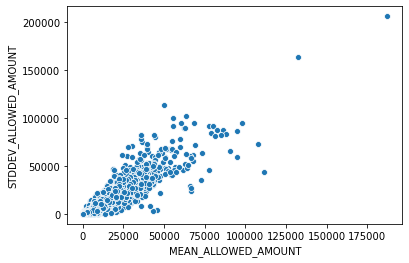

In [18]:
#plot stddev vs mean
ax = sns.scatterplot(y='STDDEV_ALLOWED_AMOUNT', x='MEAN_ALLOWED_AMOUNT', data=aa_trim_std_df)


### Generate Regression data frames

#### Model Formula

\begin{equation*}
log(y_i-y_m-\overline{p})=\overrightarrow{STATE_i}+\overrightarrow{PAYERID_i}+\overrightarrow{PROCEDURE_i}+\overrightarrow{CHANNEL_i}\end{equation*}

\begin{equation*}
y_m: trimmed mean procedure price
\end{equation*}

\begin{equation*}
\overline{p}: trimmed mean procedure price
\end{equation*}


\begin{equation*}
\overrightarrow{STATE_i}: vector of state dummy variables
\end{equation*}

\begin{equation*}
\overrightarrow{PAYERID_i}: vector of payer IDs
\end{equation*}

\begin{equation*}
\overrightarrow{PROCEDURE_i}: vector of procedure ids
\end{equation*}

\begin{equation*}
\overrightarrow{CHANNEL_i}: vector of channel ids
\end{equation*}

In [46]:
sample_size=100000
runs=25

In [21]:
def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    return current_time

In [22]:
rmse_mean=[]
rmse_fit=[]

### Run Sampled Regression

In [47]:
#sample from trimmed price data frame

for j in range(runs):


    start_time=datetime.now()
    print("Starting loop ", j, get_time())

    #sample data 
    temp_df=pull_snfdb(db=snf_trim_px_db,
                   sample_n=sample_size)
    print("    Ended sample pull ", get_time())
    #define y as log amount minus global mean minus procedure mean
    temp_df["LOG_ALLOWED_AMOUNT"]=np.log(temp_df["ALLOWED_AMOUNT"])
    temp_df["LOG_ALLOWED_AMOUNT_CENTER"]=np.log(temp_df["ALLOWED_AMOUNT"])/np.log(px_trim_mean)
    temp_df["LOG_ALLOWED_AMOUNT_CENTER_ADJUSTED"]=temp_df["LOG_ALLOWED_AMOUNT_CENTER"]/np.log(temp_df["TRIM_5_MEAN"])

    #convert booleans to ints
    temp_df["PAYER_KH_ID_IMPUTE_FLAG_INT"] = temp_df.PAYER_KH_ID_IMPUTE_FLAG.replace({True: 1, False: 0})
    temp_df["SOURCE_ROWLEY_INT"] = temp_df.SOURCE_ROWLEY.replace({True: 1, False: 0})
    temp_df["SOURCE_FLEMINGSALK_INT"] = temp_df.SOURCE_FLEMINGSALK.replace({True: 1, False: 0})
    temp_df["SOURCE_FLEMINGPESO_INT"] = temp_df.SOURCE_FLEMINGPESO.replace({True: 1, False: 0})
    temp_df["SOURCE_FLEMINGNIGHTINGALE_INT"] = temp_df.SOURCE_FLEMINGNIGHTINGALE.replace({True: 1, False: 0})

    #declare reg variables and create regression data frame
    yName='LOG_ALLOWED_AMOUNT_CENTER_ADJUSTED'
    px_reg_df=pd.concat([pd.get_dummies(temp_df.PATIENT_STATE, prefix="STATE"), pd.get_dummies(temp_df.PAYER_KH_ID, 
                    prefix="PAYER"),pd.get_dummies(temp_df.PROCEDURE, prefix="PROCEDURE"),
                    pd.get_dummies(temp_df.CHANNEL, prefix="CHANNEL"),
                     temp_df[['PAYER_KH_ID_IMPUTE_FLAG_INT', 'SOURCE_ROWLEY_INT', 'SOURCE_FLEMINGSALK_INT',
                               'SOURCE_FLEMINGPESO_INT', 'SOURCE_FLEMINGNIGHTINGALE_INT']]], axis=1)
    xNames=px_reg_df.columns
    px_reg_df=pd.concat([temp_df[yName],px_reg_df], axis=1)

    #split into training, test frames
    X_train, X_test, y_train, y_test = train_test_split(px_reg_df[xNames],
                                                    px_reg_df[yName],
                                                    test_size=0.25, random_state=0)

    #fit model via elasticnet
    eNetReg = ElasticNetCV(normalize=True)
    eNetReg.fit(X_train, y_train)
    yFit=eNetReg.predict(X_test)
    
    print("    Fit model", get_time())
    
    #store coefficients
    coefDF=pd.DataFrame({"coef":X_test.columns.values, "valCoefs": eNetReg.coef_})

    for i in range(len(X_test.columns.values)):
        temp_list=enet_coef_results.get(X_test.columns.values[i],[])
        temp_list.append(eNetReg.coef_[i])
        enet_coef_results[X_test.columns.values[i]]=temp_list

    #calculate and store rmse
    rmse_mean.extend([sqrt(mse(y_test,[np.mean(y_train)]*len(y_test)))])
    rmse_fit.extend([sqrt(mse(yFit,y_test))])
    
    #print results
    print ("    No model rmse: ", rmse_mean[-1])
    print ("    Model rmse: ",rmse_fit[-1])
    
    print("    Total loop time", datetime.now()-start_time)
    

Starting loop  0 20:38:13
    Ended sample pull  20:38:50
    Fit model 20:42:15
    No model rmse:  0.46453548392165445
    Model rmse:  0.2611429140773535
    Total loop time 0:04:02.440295
Starting loop  1 20:42:15
    Ended sample pull  20:42:24
    Fit model 20:45:54
    No model rmse:  1.0568837887077294
    Model rmse:  1.057116698679596
    Total loop time 0:03:38.722012
Starting loop  2 20:45:54
    Ended sample pull  20:46:02
    Fit model 20:49:26
    No model rmse:  0.08922288284189785
    Model rmse:  0.0815181820628682
    Total loop time 0:03:32.612621
Starting loop  3 20:49:26
    Ended sample pull  20:49:34
    Fit model 20:52:55
    No model rmse:  0.1691953946220815
    Model rmse:  0.24547027094496182
    Total loop time 0:03:28.652020
Starting loop  4 20:52:55
    Ended sample pull  20:53:02
    Fit model 20:56:42
    No model rmse:  0.2505793813066237
    Model rmse:  0.20419015247900313
    Total loop time 0:03:46.748897
Starting loop  5 20:56:42
    Ended sample

### Print Results of Sampled Regressions

In [48]:
#set reg col names (needs to be reset if new columns added)
xreg_col_names=X_test.columns.values

In [49]:
#store results of runs in dictionary indexed by column names
enet_coef_results={}
for col in xreg_col_names:
    enet_coef_results[col]=[]
    

In [50]:
print ("No model rmse", np.mean(rmse_mean))

No model rmse 0.5183906946759451


In [51]:
print (np.mean(rmse_fit))

0.34104078968480783


In [52]:
yFit=[np.mean(X_train)]*len(X_test)
y_trim_Fit=[np.mean(X_trim_train)]*len(X_trim_test)
pred_mse.extend([sqrt(mse(exp(yFit),exp(X_test)))])
pred_5p_trim_mse.extend([sqrt(mse(exp(y_trim_Fit),exp(X_trim_test)))])

NameError: name 'X_trim_train' is not defined

In [ ]:
temp_df.columns

In [ ]:
px_reg_df.head()

In [ ]:
enet_coef_results

### h2o Test

In [35]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_252"; OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09); OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn80m47b2
  JVM stdout: /tmp/tmpn80m47b2/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmpn80m47b2/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_jovyan_fho28m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.20 Gb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


In [45]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=1800, seed=1)
trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train ], axis=1))
testH2o=h2o.H2OFrame(pd.concat([y_test,X_test], axis=1))
aml.train(x=xNames.tolist(), y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
20:04:49.363: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [53]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20200923_200449,0.0538497,0.232055,0.0538497,0.0430717,nan
StackedEnsemble_AllModels_AutoML_20200923_200449,0.0550182,0.23456,0.0550182,0.0428493,nan
GLM_1_AutoML_20200923_200449,0.0978393,0.312793,0.0978393,0.0424971,nan
XGBoost_3_AutoML_20200923_200449,0.116541,0.341382,0.116541,0.190801,nan
XGBoost_1_AutoML_20200923_200449,0.131677,0.362873,0.131677,0.190306,nan
XGBoost_2_AutoML_20200923_200449,0.135456,0.368044,0.135456,0.19163,nan


In [54]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20200923_200449

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.018456219041449878
RMSE: 0.1358536677511869
MAE: 0.042277732369016406
RMSLE: NaN
R^2: 0.7197785648808512
Mean Residual Deviance: 0.018456219041449878
Null degrees of freedom: 9915
Residual degrees of freedom: 9913
Null deviance: 653.0973483337377
Residual deviance: 183.011868015017
AIC: -11439.792181489584

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.053849718728594155
RMSE: 0.23205542167463822
MAE: 0.04307168691397011
RMSLE: NaN
R^2: 0.4538492567503153
Mean Residual Deviance: 0.053849718728594155
Null degrees of freedom: 24999
Residual degrees of freedom: 24997
Null deviance: 2464.965925137148
Residual deviance: 1346.2429682148538
AIC: -2084.025805569242

ModelMetricsRegressionGLM: stackedensemble
** Report

### Old Code (for review)

In [34]:
coefDF

,coef,valCoefs
0,STATE_AK,0.000000
1,STATE_AL,0.000000
2,STATE_AR,-0.000000
3,STATE_AZ,-0.000000
4,STATE_CA,-0.000000
...,...,...
4938,PAYER_KH_ID_IMPUTE_FLAG_INT,-0.000000
4939,SOURCE_ROWLEY_INT,0.000000
4940,SOURCE_FLEMINGSALK_INT,-0.001911
4941,SOURCE_FLEMINGPESO_INT,0.008045


In [9]:
temp_df.head().T

,0,1,2,3,4
ENCOUNTER_KEY,711a2cae252a3cd14e259a8748c527b723b17fcf,621953566ec23be5fb06d0a84f39ed2678342982,be44423c90b2d044d20c053c6e5f1cf6ef17dacc,35abd0a59f6318ae8e258fc9fde05a34827e532d,6bacbb539ae0e2aae2f0cb72c13e1891d8326d2b
ALLOWED_AMOUNT,70.71,9.44,97.6,4.98,141
PROCEDURE,97597,73030,W1793,81025,99213
PROCEDURE_DESCRIPTION,Removal of tissue from wounds per session,"X-ray of shoulder, minimum of 2 views",None,Urine pregnancy test,Established patient office or other outpatient...
PATIENT_STATE,NJ,NY,PA,WI,FL
TOTAL_CLAIM_CHARGE_AMOUNT,401.28,12,97.6,0.47,141
PAYER_KH_ID,67,309,82,44,195
PAYER_KH_ID_IMPUTE_FLAG,False,False,False,False,True
SOURCE_ROWLEY,True,True,False,True,False
SOURCE_FLEMINGSALK,False,False,False,False,True


In [10]:
temp_df_5p_trim=temp_df[(temp_df.ALLOWED_AMOUNT>temp_df.PERCENTILE_5) & 
                      (temp_df.ALLOWED_AMOUNT<temp_df.PERCENTILE_95)]
temp_df_10p_trim=temp_df[(temp_df.ALLOWED_AMOUNT>temp_df.PERCENTILE_10) & 
                      (temp_df.ALLOWED_AMOUNT<temp_df.PERCENTILE_90)]

In [21]:
print(temp_df.shape)
print(temp_df_5p_trim.shape)
print(temp_df_10p_trim.shape)

(1000, 24)
(905, 24)
(807, 24)


In [22]:
print(np.mean(temp_df.ALLOWED_AMOUNT))
print(np.mean(temp_df_5p_trim.ALLOWED_AMOUNT))
print(np.mean(temp_df_10p_trim.ALLOWED_AMOUNT))

123.76563
107.21719337016575
105.97517967781909


In [23]:
print(np.median(temp_df.ALLOWED_AMOUNT))
print(np.median(temp_df_5p_trim.ALLOWED_AMOUNT))
print(np.median(temp_df_10p_trim.ALLOWED_AMOUNT))

56.120000000000005
53.52
52.99


In [24]:
print(np.std(temp_df.ALLOWED_AMOUNT))
print(np.std(temp_df_5p_trim.ALLOWED_AMOUNT))
print(np.std(temp_df_10p_trim.ALLOWED_AMOUNT))


297.9945169740596
257.67671269322733
252.65308179881725


In [25]:
temp_df_proc_summ=temp_df.groupby(['PROCEDURE']).agg(
                      {'ALLOWED_AMOUNT':['mean','std','median']}).reset_index()
temp_df_proc_summ.columns = ['procedure','mean','std','median']
temp_df_proc_summ.reindex(columns=sorted(temp_df_proc_summ.columns))
temp_df_proc_5p_summ=temp_df_5p_trim.groupby(['PROCEDURE']).agg(
                      {'ALLOWED_AMOUNT':['mean','std','median']}).reset_index()
temp_df_proc_5p_summ.columns = ['procedure','mean','std','median']
temp_df_proc_5p_summ.reindex(columns=sorted(temp_df_proc_5p_summ.columns))
temp_df_proc_10p_summ=temp_df_10p_trim.groupby(['PROCEDURE']).agg(
                      {'ALLOWED_AMOUNT':['mean','std','median']}).reset_index()
temp_df_proc_10p_summ.columns = ['procedure','mean','std','median']
temp_df_proc_10p_summ.reindex(columns=sorted(temp_df_proc_10p_summ.columns))

,mean,median,procedure,std
0,144.00,144.00,00400,NaN
1,1.77,1.77,00409120703,NaN
2,133.18,133.18,00731,NaN
3,129.86,129.86,00811,NaN
4,762.47,762.47,00840,NaN
...,...,...,...,...
390,54.88,54.88,T4526,NaN
391,27.50,27.50,V2100,NaN
392,69.00,69.00,V2784,NaN
393,136.64,136.64,W1793,55.210897


In [26]:
temp_df_proc_summ.describe()

,mean,std,median
count,462.000000,137.000000,462.000000
mean,164.983119,75.317934,159.822370
std,391.964318,186.849081,390.439282
min,0.010000,0.000000,0.010000
25%,18.847500,4.209424,17.212500
50%,58.260000,16.510682,57.590000
75%,157.194286,55.332822,145.780000
max,5021.280000,1202.911805,5021.280000


In [27]:
temp_df_proc_5p_summ.describe()


,mean,std,median
count,431.000000,126.000000,431.000000
mean,141.428814,41.763485,139.528434
std,351.559614,91.304633,351.562033
min,0.010000,0.000000,0.010000
25%,17.320000,3.627458,16.635000
50%,51.900000,11.713109,50.790000
75%,134.805000,37.631426,132.590000
max,5021.280000,686.409766,5021.280000


In [28]:
temp_df_proc_10p_summ.describe()

,mean,std,median
count,395.000000,112.000000,395.000000
mean,136.381217,37.129959,134.514873
std,339.914866,87.552800,339.612859
min,0.010000,0.000000,0.010000
25%,16.635000,2.837297,16.480000
50%,50.926667,8.227187,50.000000
75%,134.230000,23.422529,129.235000
max,5021.280000,686.409766,5021.280000


In [66]:
X_test.shape

(250, 621)

In [67]:
sqrt(mse(exp(yFit),exp(y_test)))

212.5308915231473

In [43]:
pred_mse=[]
pred_5p_trim_mse=[]
for __ in range(100):
    X_train, X_test= train_test_split(temp_df[yName],
                                                    test_size=0.25)
    X_trim_train, X_trim_test= train_test_split(temp_df_5p_trim[yName],
                                                    test_size=0.25)
    #basic model-no factors
    yFit=[np.mean(X_train)]*len(X_test)
    y_trim_Fit=[np.mean(X_trim_train)]*len(X_trim_test)
    pred_mse.extend([sqrt(mse(exp(yFit),exp(X_test)))])
    pred_5p_trim_mse.extend([sqrt(mse(exp(y_trim_Fit),exp(X_trim_test)))])
    


In [44]:
np.mean(pred_mse)

297.930299668922

In [ ]:
np.mean(pred_5p_trim_mse)

In [ ]:
exp()

In [ ]:
[np.exp(np.mean(X_train))]*len(X_test)

In [ ]:
resid_df=pd.DataFrame({"x":np.exp(X_test["LOG_ALLOWED_AMOUNT"]), "y":np.exp(np.mean(X_train["LOG_ALLOWED_AMOUNT"]))})
resid_df2=pd.DataFrame({"x":X_test["LOG_ALLOWED_AMOUNT"], "y":np.mean(X_train["LOG_ALLOWED_AMOUNT"])})

In [ ]:
resid_df["SE"]=(resid_df.x-resid_df.y)**2

In [ ]:
resid_df2["SE"]=(resid_df2.x-resid_df2.y)**2
resid_df2["ESE"]=np.exp((resid_df2.x-resid_df2.y)**2)

In [ ]:
np.sqrt(np.mean(resid_df.SE))

In [ ]:
np.exp(np.sqrt(np.mean(resid_df2.SE)))

In [ ]:
temp_df.loc[993]

In [ ]:
resid_df

In [ ]:
resid_df2

In [68]:
coefDF=pd.DataFrame({"coef":X_test.columns.values, "valCoefs": eNetReg.coef_})
coefDF=coefDF[coefDF.valCoefs.values!=0]
print(coefDF.sort_values(by=['valCoefs'],ascending=False))

                coef  valCoefs
418  PROCEDURE_93458  3.275959
396  PROCEDURE_90999  2.932817
162  PROCEDURE_01480  2.666378
230  PROCEDURE_70450  2.524007
564  PROCEDURE_J0178  2.518099
..               ...       ...
572  PROCEDURE_J1200 -3.240034
585  PROCEDURE_J7620 -4.095475
185  PROCEDURE_1160F -4.448883
182  PROCEDURE_1125F -6.231344
184  PROCEDURE_1159F -6.797520

[438 rows x 2 columns]


In [73]:
coefDF.coef.values

array(['STATE_AK', 'STATE_AL', 'STATE_AZ', 'STATE_CA', 'STATE_CO',
       'STATE_CT', 'STATE_DC', 'STATE_DE', 'STATE_FL', 'STATE_GA',
       'STATE_HI', 'STATE_IA', 'STATE_ID', 'STATE_IL', 'STATE_IN',
       'STATE_KS', 'STATE_KY', 'STATE_LA', 'STATE_MD', 'STATE_ME',
       'STATE_MI', 'STATE_MN', 'STATE_MO', 'STATE_NC', 'STATE_ND',
       'STATE_NE', 'STATE_NH', 'STATE_NJ', 'STATE_NY', 'STATE_PA',
       'STATE_SC', 'STATE_TX', 'STATE_UT', 'STATE_VA', 'STATE_WA',
       'STATE_WI', 'STATE_WV', 'STATE_WY', 'PAYER_1', 'PAYER_102',
       'PAYER_103', 'PAYER_108', 'PAYER_11', 'PAYER_129', 'PAYER_134',
       'PAYER_14', 'PAYER_143', 'PAYER_144', 'PAYER_148', 'PAYER_157',
       'PAYER_16', 'PAYER_161', 'PAYER_164', 'PAYER_165', 'PAYER_17',
       'PAYER_18', 'PAYER_181', 'PAYER_182', 'PAYER_184', 'PAYER_186',
       'PAYER_189', 'PAYER_192', 'PAYER_21', 'PAYER_214', 'PAYER_216',
       'PAYER_221', 'PAYER_225', 'PAYER_241', 'PAYER_243', 'PAYER_250',
       'PAYER_251', 'PAYER_260', 'PAYE

In [70]:
coefDF.T

,0,1,3,4,5,6,7,8,9,10,...,607,609,610,611,612,615,616,617,618,620
coef,STATE_AK,STATE_AL,STATE_AZ,STATE_CA,STATE_CO,STATE_CT,STATE_DC,STATE_DE,STATE_FL,STATE_GA,...,PROCEDURE_T2042,PROCEDURE_T4530,PROCEDURE_T4535,PROCEDURE_V2100,PROCEDURE_V2784,PROCEDURE_W9047,PAYER_KH_ID_IMPUTE_FLAG_INT,SOURCE_ROWLEY_INT,SOURCE_FLEMINGSALK_INT,SOURCE_FLEMINGNIGHTINGALE_INT
valCoefs,0.49417,-0.276112,-0.0739494,-0.113058,0.102492,0.132339,0.0105948,-0.270907,-0.121271,-0.115809,...,0.249168,1.17236,-0.522055,-0.233765,0.028717,0.74995,-0.108201,-0.0399801,-0.211195,-0.0821781
